## Neural Style Transfer using VGG-19

In [1]:

# Content and Style Information in Different Layers
# The reason for selecting these layers is rooted in the separation of content and style information. Content information is typically captured in deeper layers (e.g., conv4_1, conv5_1)
# , while style information is encoded in both shallow and deep layers (e.g., conv1_1, conv2_1, conv3_1).

# Calculating Feature Loss
# The features extracted from these chosen layers are then used to calculate feature loss. Feature loss measures the difference between the features of the generated image and
# those of the content and style reference images. This loss guides the optimization process to generate an image that matches the content of the reference image while
# incorporating the style from another.

# Balancing Content and Style
# By choosing layers that represent both content and style aspects, the NST model strikes a balance between faithfully reproducing the content of the original image and
# adopting the stylistic features of the reference image. The combination of feature loss at multiple layers ensures a holistic transfer of both content and style information.

# Basic idea is to take a random genertaed image at first , the original image , the style that we wnat to learn. then we extract features from the generated, original and style image using
# certain feature map outputs from vgg 19 as mentioned above and caluclate the graham matrix , wheich helps identify style features of the feature map. then we comapre the features of the generated image ftrs
# with the original image ftrs and calulate loss. this helps us to identify the loss of the original image / content loss , and comparing genertaed image with the style ftrs , we get the loss for style
# using a combined wted loss we backpropagate it on the generated iamge , which updates itself accordingly.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

# custom vgg class for feature extraction
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        #  These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 as mentioned in the NST paper
        # we use the outputs of the below channels to extract features from the output feature maps

        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # pass input through  each layer in model, if the layer is in the chosen_features,
        # store it in features.
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features


def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

# Here we may want to use the Normalization constants used in the original
# VGG network (to get similar values net was originally trained on), but
# I found it didn't matter too much so I didn't end of using it.
loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

original_img = load_image("man.jpg")
style_img = load_image("style.jpg")

# initialized generated as white noise or clone of original image.
# Clone seemed to work better for me.
# generated = torch.randn(original_img.data.shape, device=device, requires_grad=True)
generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()

total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.4
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features):

        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)


      # gram matrix heps us identify features, styles and patterns  within the extracted feature map
      # it is similar to a correlation matrix
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t())

        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t())

        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    print(f"Step {step} ; total loss {total_loss} ; orginal_loss {original_loss} ; style_loss :{style_loss}")

    save_image(generated, "generated_method1.png")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 102MB/s] 


Streaming output truncated to the last 5000 lines.
Step 1000 ; total loss 604721.5625 ; orginal_loss 18.821977615356445 ; style_loss :1511756.875
Step 1001 ; total loss 604159.75 ; orginal_loss 18.823463439941406 ; style_loss :1510352.25
Step 1002 ; total loss 603598.5 ; orginal_loss 18.82491683959961 ; style_loss :1508949.125
Step 1003 ; total loss 603037.75 ; orginal_loss 18.826356887817383 ; style_loss :1507547.375
Step 1004 ; total loss 602477.625 ; orginal_loss 18.827823638916016 ; style_loss :1506147.0
Step 1005 ; total loss 601918.25 ; orginal_loss 18.8293514251709 ; style_loss :1504748.5
Step 1006 ; total loss 601359.4375 ; orginal_loss 18.83091163635254 ; style_loss :1503351.5
Step 1007 ; total loss 600801.125 ; orginal_loss 18.83246612548828 ; style_loss :1501955.75
Step 1008 ; total loss 600243.4375 ; orginal_loss 18.833999633789062 ; style_loss :1500561.5
Step 1009 ; total loss 599686.3125 ; orginal_loss 18.835494995117188 ; style_loss :1499168.75
Step 1010 ; total loss 599

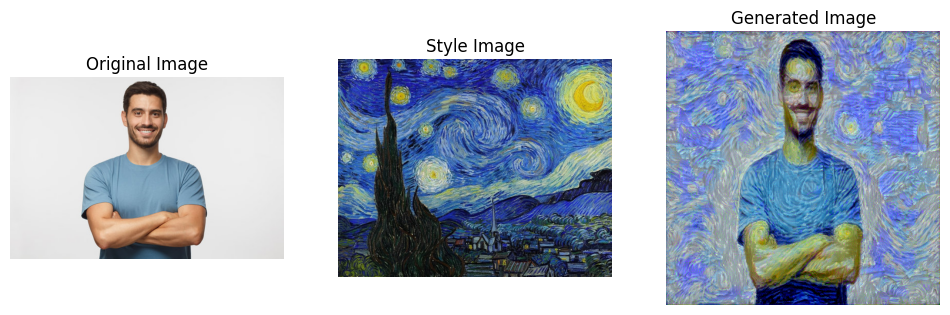

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_image_path = "man.jpg"
style_image_path = "style.jpg"
generated_image_path = "generated_method1.png"

original_image = mpimg.imread(original_image_path)
style_image = mpimg.imread(style_image_path)
generated_image = mpimg.imread(generated_image_path)

plt.figure(figsize=(12, 20))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Style image
plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title("Style Image")
plt.axis("off")

# Generated image
plt.subplot(1, 3, 3)
plt.imshow(generated_image)
plt.title("Generated Image")
plt.axis("off")

plt.show()


# Using GANs for Neural Transfer

## GANs for Neural Style Transfer: A Trial and Challenges

I also tried to use Gans for  neural style transfer as I'd read about it in some papers. While GANs offer the potential for more realistic and detailed results, the implementation came with its set of challenges.


   - One major challenge was the slow learning speed and difficulties in updating the generator and discriminator weights effectively.
   - The intricacies of balancing adversarial loss, content loss, and style loss contributed to slow convergence.
   - Training GANs for neural style transfer was computationally intensive, limiting the duration of training sessions.
   - Longer training times might have led to more refined and detailed stylizations, but the computational demands were a constraint.

### Observations :

- **Initial Learning:**
  - in the output generated image we can see that the model had started to learn the features and we can see the grooves coming just like in the style image. could have trainded for longer , but was computationally intensive
  - Despite challenges, the model showed promise in capturing style features, evident in the appearance of grooves reminiscent of the style image.
  - This early success indicated that the model was starting to learn the intricate details of the style.

- **Need for Prolonged Training:**
  - While the generated images demonstrated early learning, extending the training duration could have yielded even more sophisticated stylizations.
  - Longer training sessions would likely have allowed the model to better understand and incorporate subtle style nuances.
 the way for more efficient and visually appealing stylized image generation.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
import torch.nn.functional as F

import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(128, output_channels, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.tanh(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=3, stride=2, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.conv3(x)
        x = self.sigmoid(x)
        return x

class VGGFeatures(nn.Module):
    def __init__(self):
        super(VGGFeatures, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

imsize = 500

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_channels = 3
output_channels = 3

# Initializing the generator and discriminator
generator = Generator(input_channels, output_channels).to(device)
discriminator = Discriminator(output_channels).to(device)

# Defining the VGG model for feature extraction
vgg_model = VGGFeatures().to(device).eval()

# Hyperparameters
total_steps = 100
learning_rate = 0.001
alpha = 1
beta = 0.5

# Defining the optimizer for both networks
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

content_image = load_image("man.jpg")
style_image = load_image("style.jpg")

# Training loop
for epoch in range(total_steps):
    # Generator training loop
    for i in range(10):
        # Generate a stylized image
        generated_image = generator(content_image)

        # Extract features from the generated, original, and style images using VGG
        generated_features = vgg_model(generated_image)
        original_features = vgg_model(content_image)
        style_features = vgg_model(style_image)

        style_loss =content_loss= 0

        for gen_feature, orig_feature, style_feature in zip(generated_features, original_features, style_features):

            batch_size, channel, height, width = gen_feature.shape
            content_loss += torch.mean((gen_feature - orig_feature) ** 2)

            # Compute Gram Matrix of generated
            G = gen_feature.view(channel, height * width).mm(
                gen_feature.view(channel, height * width).t()
            )
            # Compute Gram Matrix of Style
            A = style_feature.view(channel, height * width).mm(
                style_feature.view(channel, height * width).t())

            style_loss += torch.mean((G - A) ** 2)

        # Calculate the generator loss (adversarial loss)
        fake_pred = discriminator(generated_image)
        generator_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.ones_like(fake_pred))

        # Total loss
        total_loss = alpha * content_loss + beta * style_loss + generator_loss

        # Update the generator parameters
        optimizer_g.zero_grad()
        total_loss.backward()
        optimizer_g.step()

    # Discriminator training loop
#     for i in range(5):
        # Update the discriminator parameters
        real_pred = discriminator(content_image)
        fake_pred = discriminator(generated_image.detach())
        real_loss = F.binary_cross_entropy_with_logits(real_pred, torch.ones_like(real_pred))
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, torch.zeros_like(fake_pred))
        discriminator_loss = real_loss + fake_loss

        optimizer_d.zero_grad()
        discriminator_loss.backward()
        optimizer_d.step()

        print(f"Epoch [{epoch}/{total_steps}], Generator Iteration [{i}/10]")
        print(f"Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}, Generator Loss: {generator_loss.item()}, Discriminator Loss: {discriminator_loss.item()}")

    # Save the generated image
#     if epoch % 10 == 0:
        save_image(generated_image, f"generated.png")


Epoch [0/100], Generator Iteration [0/10]
Content Loss: 6.639293670654297, Style Loss: 399368768.0, Generator Loss: 0.47317254543304443, Discriminator Loss: 1.4384353160858154
Epoch [0/100], Generator Iteration [1/10]
Content Loss: 7.076045036315918, Style Loss: 896127808.0, Generator Loss: 0.48394930362701416, Discriminator Loss: 1.383943796157837
Epoch [0/100], Generator Iteration [2/10]
Content Loss: 7.057533264160156, Style Loss: 381019840.0, Generator Loss: 0.4911840856075287, Discriminator Loss: 1.34018874168396
Epoch [0/100], Generator Iteration [3/10]
Content Loss: 6.509637832641602, Style Loss: 360785568.0, Generator Loss: 0.4942674934864044, Discriminator Loss: 1.3062375783920288
Epoch [0/100], Generator Iteration [4/10]
Content Loss: 6.5620880126953125, Style Loss: 443426400.0, Generator Loss: 0.49918708205223083, Discriminator Loss: 1.2770942449569702
Epoch [0/100], Generator Iteration [5/10]
Content Loss: 6.695186614990234, Style Loss: 426976512.0, Generator Loss: 0.513535

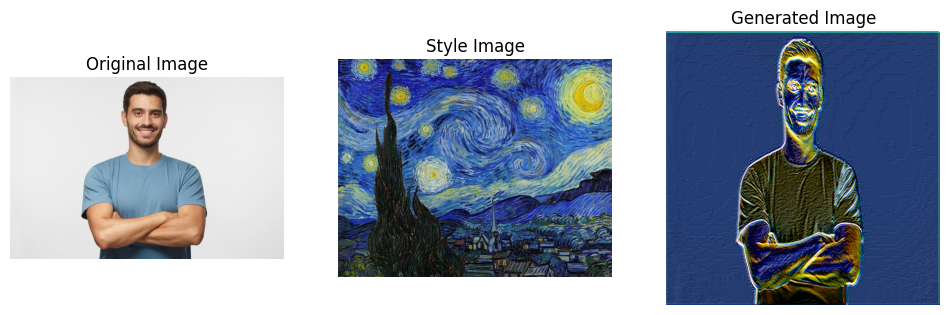

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Replace these with the actual filenames of your images
original_image_path = "man.jpg"
style_image_path = "style.jpg"
generated_image_path = "generated.png"

# Load images
original_image = mpimg.imread(original_image_path)
style_image = mpimg.imread(style_image_path)
generated_image = mpimg.imread(generated_image_path)

# Plot the images side by side
plt.figure(figsize=(12, 20))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Style image
plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title("Style Image")
plt.axis("off")

# Generated image
plt.subplot(1, 3, 3)
plt.imshow(generated_image)
plt.title("Generated Image")
plt.axis("off")

plt.show()


## Method 2 - Using Adaptive Instance Normalization

 I employed Adaptive Instance Normalization (AdaIN) in the context of neural style transfer for its effectiveness in separating and recombining content and style information. AdaIN dynamically adjusts the mean and standard deviation of the features in the content image to match those of the style image. This adaptive normalization allows the model to align the statistics of the content and style images, facilitating the transfer of the style while preserving the content. Unlike fixed normalization techniques, AdaIN provides a more flexible and nuanced approach, enabling the model to capture intricate style details across various scales. Its adaptability makes it well-suited for neural style transfer. Additionally, AdaIN contributes to the model's ability to generalize across different styles and content types, enhancing the overall versatility of the neural style transfer process.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

class AdaptiveInstanceNormalization(nn.Module):
    def forward(self, content_features, style_features):
        # Calculate the mean and variance of the style features
        style_mean = torch.mean(style_features, dim=[2, 3], keepdim=True)
        style_std = torch.std(style_features, dim=[2, 3], keepdim=True)

        # Normalize the content features using the style mean and variance
        normalized_features = (content_features - torch.mean(content_features, dim=[2, 3], keepdim=True)) / torch.std(content_features, dim=[2, 3], keepdim=True)

        # Apply affine transformation
        transformed_features = style_std * normalized_features + style_mean

        return transformed_features

def calculate_histogram(image):
    image_np = image.squeeze(0).detach().cpu().numpy()
    histograms = [np.histogram(channel, bins=256, range=[0, 1])[0] for channel in image_np]
    histograms = [hist / np.sum(hist) for hist in histograms]
    return histograms

def histogram_loss(image1, image2):
    histograms1 = calculate_histogram(image1)
    histograms2 = calculate_histogram(image2)
    emd_loss = sum(np.linalg.norm(hist1 - hist2, 1) for hist1, hist2 in zip(histograms1, histograms2))
    return emd_loss

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

original_img = load_image("man.jpg")
style_img = load_image("style.jpg")

generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()
adain = AdaptiveInstanceNormalization().to(device)

# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.4
gamma = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = 0
    original_loss = 0
    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)

        gen_feature_adain = adain(gen_feature, style_feature)

        G = gen_feature_adain.view(channel, height * width).mm(
            gen_feature_adain.view(channel, height * width).t())

        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        if str(torch.mean((G -A) ** 2).item())=="nan":
          continue

        style_loss += torch.mean((G - A) ** 2)

    hist_loss = histogram_loss(generated, style_img)

    total_loss = alpha * original_loss + beta * style_loss + gamma*hist_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    print(f"Step {step} ; total loss {total_loss} ; orginal_loss {original_loss} ; style_loss :{style_loss}")

    save_image(generated, "generated_method3.png")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 0 ; total loss 4730605.0 ; orginal_loss 0.0 ; style_loss :11826512.0
Step 1 ; total loss 4619109.0 ; orginal_loss 0.009708469733595848 ; style_loss :11547772.0
Step 2 ; total loss 4496014.0 ; orginal_loss 0.03934738039970398 ; style_loss :11240035.0
Step 3 ; total loss 4363943.0 ; orginal_loss 0.09314138442277908 ; style_loss :10909857.0
Step 4 ; total loss 4222534.0 ; orginal_loss 0.17836247384548187 ; style_loss :10556335.0
Step 5 ; total loss 4072753.0 ; orginal_loss 0.29476726055145264 ; style_loss :10181882.0
Step 6 ; total loss 3912610.25 ; orginal_loss 0.44728147983551025 ; style_loss :9781524.0
Step 7 ; total loss 3735093.5 ; orginal_loss 0.661176323890686 ; style_loss :9337732.0
Step 8 ; total loss 3543878.75 ; orginal_loss 0.9413480162620544 ; style_loss :8859694.0
Step 9 ; total loss 3349285.0 ; orginal_loss 1.2597322463989258 ; style_loss :8373209.0
Step 10 ; total loss 3155630.75 ; orginal_loss 1.6112337112426758 ; style_loss :7889073.0
Step 11 ; total loss 2967932.5 

## Results for using Adaptive Instance Normalization

Here in the results we can see that using ADAIN has preserved the original image while learning the features of the style inside it

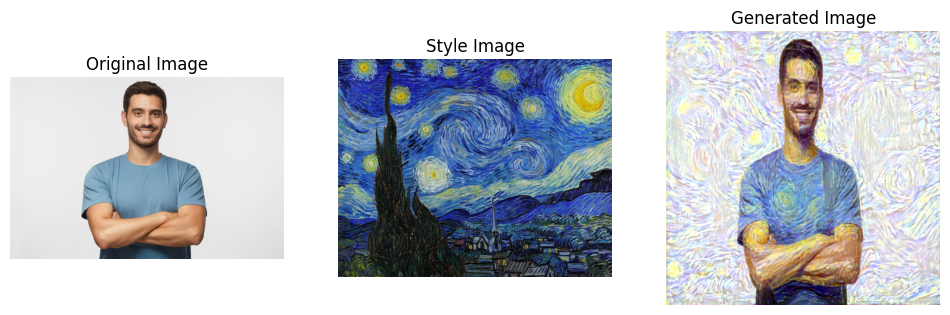

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_image_path = "man.jpg"
style_image_path = "style.jpg"
generated_image_path = "generated_method2.png"

original_image = mpimg.imread(original_image_path)
style_image = mpimg.imread(style_image_path)
generated_image = mpimg.imread(generated_image_path)

plt.figure(figsize=(12, 20))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Style image
plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title("Style Image")
plt.axis("off")

# Generated image
plt.subplot(1, 3, 3)
plt.imshow(generated_image)
plt.title("Generated Image")
plt.axis("off")

plt.show()


## Using Histogram Loss along with previous Base Model


The incorporation of histogram loss and histogram features in neural style transfer (NST) serves as a strategic augmentation to the traditional loss functions, aiming to enhance the fidelity of stylized images. Histogram loss is introduced to measure the similarity in pixel intensity distributions between the generated image and the style reference. By considering the entire intensity spectrum, histogram loss contributes to capturing global style characteristics that may be overlooked by traditional feature losses. This inclusiveness allows for a more holistic assessment of the style representation, promoting a nuanced and comprehensive stylization process.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image


class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]

        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

class AdaptiveInstanceNormalization(nn.Module):
    def forward(self, content_features, style_features):
        # Calculate the mean and variance of the style features
        style_mean = torch.mean(style_features, dim=[2, 3], keepdim=True)
        style_std = torch.std(style_features, dim=[2, 3], keepdim=True)

        # Normalize the content features using the style mean and variance
        normalized_features = (content_features - torch.mean(content_features, dim=[2, 3], keepdim=True)) / torch.std(content_features, dim=[2, 3], keepdim=True)

        # Apply affine transformation
        transformed_features = style_std * normalized_features + style_mean

        return transformed_features

def calculate_histogram(image):
    image_np = image.squeeze(0).detach().cpu().numpy()
    histograms = [np.histogram(channel, bins=256, range=[0, 1])[0] for channel in image_np]
    histograms = [hist / np.sum(hist) for hist in histograms]
    return histograms

def histogram_loss(image1, image2):
    histograms1 = calculate_histogram(image1)
    histograms2 = calculate_histogram(image2)
    emd_loss = sum(np.linalg.norm(hist1 - hist2, 1) for hist1, hist2 in zip(histograms1, histograms2))
    return emd_loss

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 512

loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


original_img = load_image("man.jpg")
style_img = load_image("style.jpg")
alpha = 0.4
blended_image = alpha * original_img + (1 - alpha) * style_img
#
# # Initializing the generated tensor with the blended image
generated = blended_image.clone().requires_grad_(True)

# generated = torch.randn(original_img.data.shape, device=device, requires_grad=True)
generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()
adain = AdaptiveInstanceNormalization().to(device)

# Hyperparameters
total_steps = 6000
learning_rate = 0.001
alpha = 0.8
beta = 0.4
gamma = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = 0
    original_loss = 0
    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)

        gen_feature_adain = adain(gen_feature, style_feature)

        G = gen_feature_adain.view(channel, height * width).mm(
            gen_feature_adain.view(channel, height * width).t())

        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        if str(torch.mean((G -A) ** 2).item())=="nan":
          continue

        style_loss += torch.mean((G - A) ** 2)

    hist_loss = histogram_loss(generated, style_img)

    total_loss = alpha * original_loss + beta * style_loss + gamma*hist_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    print(f"Step {step} ; total loss {total_loss} ; orginal_loss {original_loss} ; style_loss :{style_loss}")

    save_image(generated, "generated_method4.png")

Streaming output truncated to the last 5000 lines.
Step 1000 ; total loss 62672.9609375 ; orginal_loss 14.287474632263184 ; style_loss :156653.71875
Step 1001 ; total loss 62615.609375 ; orginal_loss 14.288383483886719 ; style_loss :156510.34375
Step 1002 ; total loss 62558.29296875 ; orginal_loss 14.289336204528809 ; style_loss :156367.046875
Step 1003 ; total loss 62501.1953125 ; orginal_loss 14.290306091308594 ; style_loss :156224.296875
Step 1004 ; total loss 62444.12890625 ; orginal_loss 14.291263580322266 ; style_loss :156081.625
Step 1005 ; total loss 62387.140625 ; orginal_loss 14.292205810546875 ; style_loss :155939.15625
Step 1006 ; total loss 62330.328125 ; orginal_loss 14.29316234588623 ; style_loss :155797.125
Step 1007 ; total loss 62273.6015625 ; orginal_loss 14.294126510620117 ; style_loss :155655.3125
Step 1008 ; total loss 62216.9375 ; orginal_loss 14.295097351074219 ; style_loss :155513.640625
Step 1009 ; total loss 62160.39453125 ; orginal_loss 14.29605484008789 ; s

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

original_image_path = "man.jpg"
style_image_path = "style.jpg"
generated_image_path = "generated_method4.png"

original_image = mpimg.imread(original_image_path)
style_image = mpimg.imread(style_image_path)
generated_image = mpimg.imread(generated_image_path)

plt.figure(figsize=(12, 20))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

# Style image
plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title("Style Image")
plt.axis("off")

# Generated image
plt.subplot(1, 3, 3)
plt.imshow(generated_image)
plt.title("Generated Image")
plt.axis("off")

plt.show()


## Training Loop for multiple image styles

Here I've written the code for training the model on a set of varying images of simialr style. the style folder must contain as many images as the no. of content inputs. Would implement properly given more time.

In [ ]:
import os

for image,style in zip(os.listdir('/content/content'),os.listdir("/content/style")):

    original_img = load_image("/content/content/"+image)
    style_img = load_image("/content/style/"+style)
    generated = original_img.clone().requires_grad_(True)
    optimizer = optim.Adam([generated], lr=learning_rate)

    for step in range(total_steps):
        # Obtain the convolution features in specifically chosen layers
        generated_features = model(generated)
        original_img_features = model(original_img)
        style_features = model(style_img)

        # Loss is 0 initially
        style_loss = original_loss = 0

        # iterate through all the features for the chosen layers
        for gen_feature, orig_feature, style_feature in zip(
            generated_features, original_img_features, style_features):

            # batch_size will just be 1
            batch_size, channel, height, width = gen_feature.shape
            original_loss += torch.mean((gen_feature - orig_feature) ** 2)
            # Compute Gram Matrix of generated
            G = gen_feature.view(channel, height * width).mm(
                gen_feature.view(channel, height * width).t())
            # Compute Gram Matrix of Style
            A = style_feature.view(channel, height * width).mm(
                style_feature.view(channel, height * width).t())
            style_loss += torch.mean((G - A) ** 2)

        total_loss = alpha * original_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        print(f"Image {image} , Style {style} --- Step {step} ; total loss {total_loss} ; orginal_loss {original_loss} ; style_loss :{style_loss}")


Overall I noticed that the basic model implemented at the top performs the best so far . other models like using CycleGans , pix2pic etc. can be beneicial and need to be experimented with . one thing we could try is using weighted attention after extracting feature maps from the base cnn , vgg in this case and propagate the weights to the combined loss for the epoch.In the basic approach given at the top the model is able to learn the stylea nd also apply it to new input images as shown in the top.

In the exploration of neural style transfer (NST), various methods were considered, each has their pros and trade-offs. One alternative method involves Feed-forward Neural Networks (FFNNs), a simpler neural network type used for NST. FFNNs operate by feeding both content and style images into the network, producing the stylized image as output. While FFNNs are less powerful compared to Generative Adversarial Networks (GANs), they are notably easier to train. Another approach is Additive Style Transfer, where the style features of the style image are added to the content features of the content image, employing techniques like Gram matrix matching or style loss. Additionally, the Normalization-Activation Transfer (NAT) method normalizes the activations of the content image to align with those of the style image, resulting in a stylized image based on activation statistics. Adaptive Instance Normalization (AdaIN), a more sophisticated technique, considers differences between content and style images, proving effective in generating consistent and realistic stylized images. Lastly, CycleGAN, a type of GAN, stands out for its ability to translate images between domains, allowing for stylization by translating images to a particular style domain and back. These are some other ways we can try for neural transfer based on our case.

In [ ]:
# try cycle gan ,pix2pix
# total variation loss ?
# train on dataset where - image style pairs , style dataset should have diff images of same style
